In [1]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

(529, 622, 3)

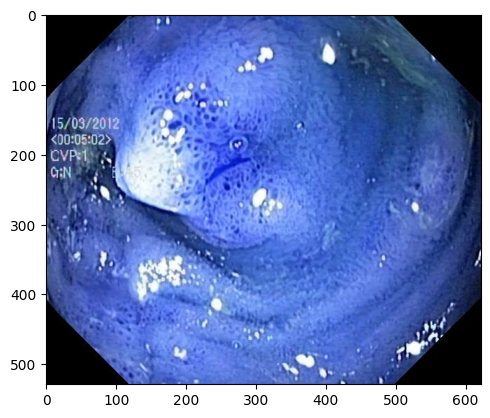

In [2]:
temp_img = cv2.imread("/kaggle/input/kvasir-seg/Kvasir-SEG/images/cju0qkwl35piu0993l0dewei2.jpg") #3 channels / spectral bands
plt.imshow(temp_img)
temp_img.shape

Labels are:  [  0   1   2   3   4   5   6   7   8 247 248 249 250 251 252 253 254 255]  and the counts are:  [703062   2415   1419    699    252    102     21     12      3      3
     12     36    126    279    690   1476   2643 273864]
(529, 622, 3)


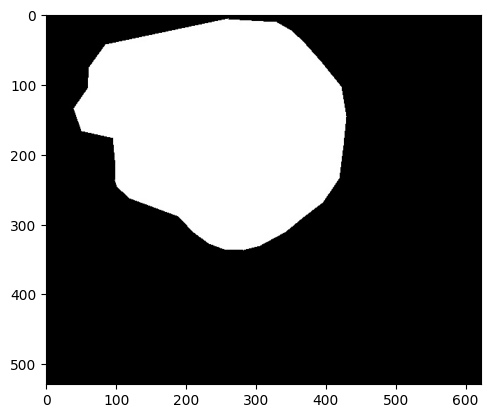

In [3]:
temp_msk = cv2.imread("/kaggle/input/kvasir-seg/Kvasir-SEG/masks/cju0qkwl35piu0993l0dewei2.jpg") #3 channels / spectral bands
plt.imshow(temp_msk)
# temp_msk.shape

labels, count = np.unique(temp_msk, return_counts=True)
print("Labels are: ", labels, " and the counts are: ", count)
print(temp_msk.shape)

In [2]:
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "image/*")))
    masks = sorted(glob(os.path.join(path, "mask/*")))

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (256, 256))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([256, 256, 3])
    y.set_shape([256, 256, 1])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

#a = read_image('/kaggle/input/kvasir-seg/Kvasir-SEG/images/cju0qkwl35piu0993l0dewei2.jpg')
#a =  ['/kaggle/input/kvasir-seg/Kvasir-SEG/images/cju7do8c72dbo0801vxfzxdc4.jpg', '/kaggle/input/kvasir-seg/Kvasir-SEG/images/cju8cgi2kspp308011nxdtjp6.jpg', '/kaggle/input/kvasir-seg/Kvasir-SEG/images/cju7dxffn2eam0817qxosfwch.jpg', '/kaggle/input/kvasir-seg/Kvasir-SEG/images/cju88rl5eo94l0850kf5wtrm1.jpg']
#dataset = tf.data.Dataset.from_tensor_slices(a)
#for item in dataset:
 #   print(item.numpy().decode('utf-8')) 

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

def conv_block(x, num_filters):
    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def build_model():
    size = 256
    #num_filters = [32, 64, 128, 256 , 512]
    num_filters = [64,128, 256, 512 , 1024]
    inputs = Input((size, size, 3))

    skip_x = []
    x = inputs
    ## Encoder
    for f in num_filters:
        x = conv_block(x, f)
        skip_x.append(x)
        x = MaxPool2D((2, 2))(x)

    ## Bridge
    x = conv_block(x, num_filters[-1])

    num_filters.reverse()
    skip_x.reverse()
    ## Decoder
    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2))(x)
        xs = skip_x[i]
        x = Concatenate()([x, xs])
        x = conv_block(x, f)

    ## Output
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)

    return Model(inputs, x)


if __name__ == "__main__":
    model = build_model()
    model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [11]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def mean_dice(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        dice = (2. * intersection + 1e-15) / (y_true.sum() + y_pred.sum() + 1e-15)
        dice = dice.astype(np.float32)
        return dice
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)


def s_measure(y_true, y_pred, alpha=0.5):
    def f(y_true, y_pred):
        # Object-aware structural similarity
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        s_object = (intersection + 1e-15) / (union + 1e-15)
        
        # Region-aware structural similarity
        y_true_mean = y_true.mean()
        y_pred_mean = y_pred.mean()
        s_region = 1 - np.abs(y_true_mean - y_pred_mean)
        
        # S-measure
        s_measure = alpha * s_object + (1 - alpha) * s_region
        return s_measure.astype(np.float32)
    
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)



def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)


def max_e_measure(y_true, y_pred):
    def f(y_true, y_pred):
        y_true = y_true.astype(np.float32)
        y_pred = y_pred.astype(np.float32)
        
        # Mean value of the ground truth
        mean_gt = y_true.mean()
        
        # Enhanced alignment matrix
        enhanced_matrix = 2 * y_pred / (y_pred + 1)
        
        # Pixel-level E-measure
        e_matrix = (1 + enhanced_matrix) * y_true / (enhanced_matrix + y_true)
        
        # Max E-measure
        e_max = e_matrix.max()
        
        return e_max.astype(np.float32)
    
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)


def weighted_f_measure(y_true, y_pred, beta=1):
    def f(y_true, y_pred):
        y_true = y_true.astype(np.float32)
        y_pred = y_pred.astype(np.float32)
        
        # Precision and Recall
        tp = (y_true * y_pred).sum()
        precision = tp / (y_pred.sum() + 1e-15)
        recall = tp / (y_true.sum() + 1e-15)
        
        # Weighted F-measure
        beta_squared = beta ** 2
        f_measure = (1 + beta_squared) * (precision * recall) / (beta_squared * precision + recall + 1e-15)
        
        return f_measure.astype(np.float32)
    
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)


In [7]:
if __name__ == "__main__":
    ## Dataset
    path = "/kaggle/input/polyp-data/TrainDataset/TrainDataset"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)
    ## Hyperparameters
    batch = 8
    lr = 1e-4
    epochs = 100

    train_dataset = tf_dataset(train_x, train_y, batch=batch)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch)
    print(train_dataset.element_spec)
    print(valid_dataset.element_spec)
#     print(train_x.element_spec)

    model = build_model()

    opt = tf.keras.optimizers.Adam(lr)
    metrics = ["acc", tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), iou, s_measure, mean_dice, max_e_measure, weighted_f_measure]
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=metrics)

    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False),
        ModelCheckpoint("model.h5", save_best_only=True)
    ]

    train_steps = len(train_x)//batch
    valid_steps = len(valid_x)//batch

    if len(train_x) % batch != 0:
        train_steps += 1
    if len(valid_x) % batch != 0:
        valid_steps += 1

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float64, name=None))
(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float64, name=None))


In [8]:
 model.fit(train_dataset,
        validation_data=valid_dataset,
        epochs=epochs,
        steps_per_epoch=train_steps,
        validation_steps=valid_steps,
        callbacks=callbacks)

Epoch 1/100
145/145 [==============================] - 140s 712ms/step - loss: 0.3535 - acc: 0.8574 - recall: 0.3827 - precision: 0.4984 - iou: 0.1940 - s_measure: 0.5440 - mean_dice: 0.3224 - max_e_measure: 1.0000 - weighted_f_measure: 0.3224 - val_loss: 0.4174 - val_acc: 0.8786 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_iou: 0.0945 - val_s_measure: 0.4779 - val_mean_dice: 0.1716 - val_max_e_measure: 1.0000 - val_weighted_f_measure: 0.1716 - lr: 1.0000e-04
Epoch 2/100
145/145 [==============================] - 100s 689ms/step - loss: 0.2741 - acc: 0.8891 - recall: 0.4277 - precision: 0.6772 - iou: 0.2495 - s_measure: 0.5982 - mean_dice: 0.3975 - max_e_measure: 1.0000 - weighted_f_measure: 0.3975 - val_loss: 0.3824 - val_acc: 0.8423 - val_recall: 0.2015 - val_precision: 0.2912 - val_iou: 0.1347 - val_s_measure: 0.5281 - val_mean_dice: 0.2355 - val_max_e_measure: 1.0000 - val_weighted_f_measure: 0.2355 - lr: 1.0000e-04
Epoch 3/100
145/145 [==============================]

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (256, 256))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

test_images = [read_image(path) for path in test_x]
test_images = np.array(test_images)

prediction_test = model.predict(test_images, batch_size=8)

true_labels = [read_mask(path) for path in test_y]
true_labels = np.array(true_labels)

binary_predictions = (prediction_test > 0.5).astype(int)
y_test_bool = (true_labels > 0.5).astype(bool)
accuracy_test = accuracy_score(np.ndarray.flatten(y_test_bool), np.ndarray.flatten(binary_predictions))
presision_score_test = precision_score(np.ndarray.flatten(y_test_bool), np.ndarray.flatten(binary_predictions))
recall_score_test = recall_score(np.ndarray.flatten(y_test_bool), np.ndarray.flatten(binary_predictions))


print(f'accuracy: {accuracy_test * 100:.2f}%')
print(f'Precision:  {presision_score_test * 100:.2f}%')
print(f'Recall : {recall_score_test * 100:.2f}%')

19/19 [==============================] - 4s 207ms/step
accuracy: 96.40%
Precision:  86.33%
Recall : 81.47%


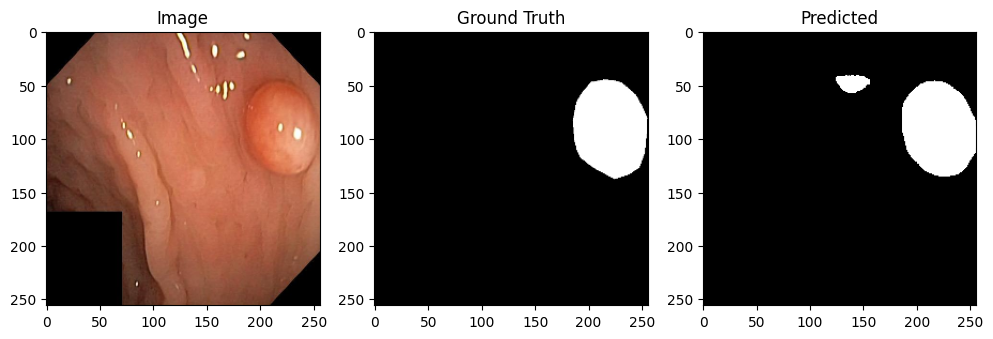

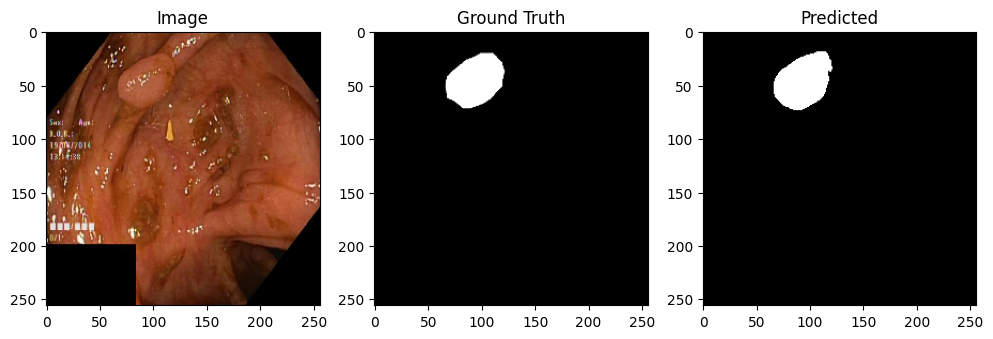

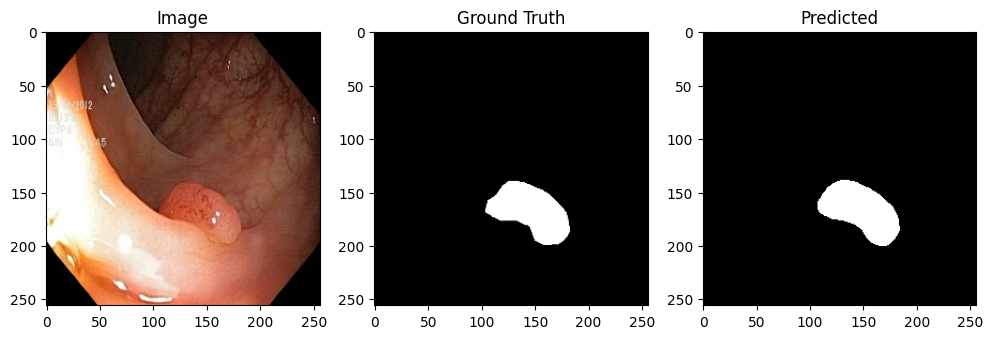

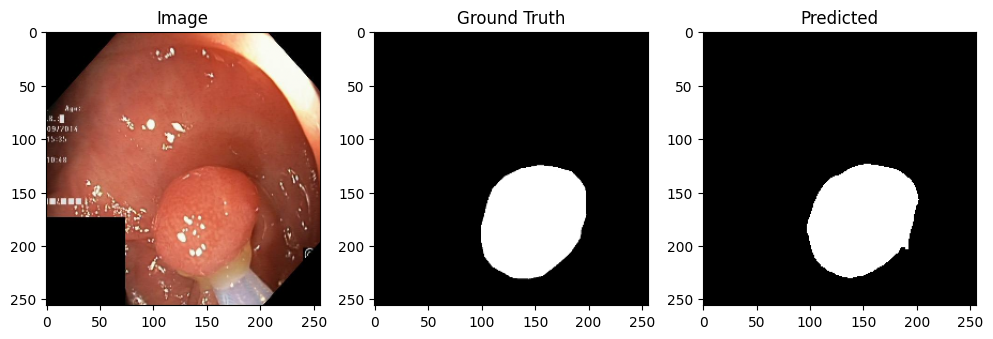

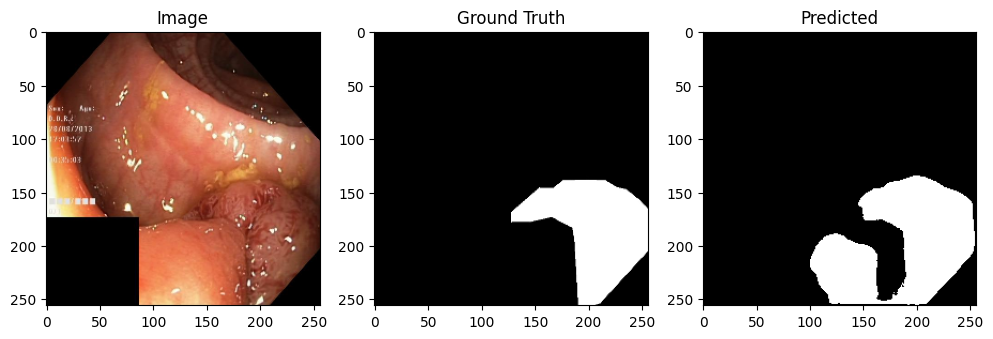

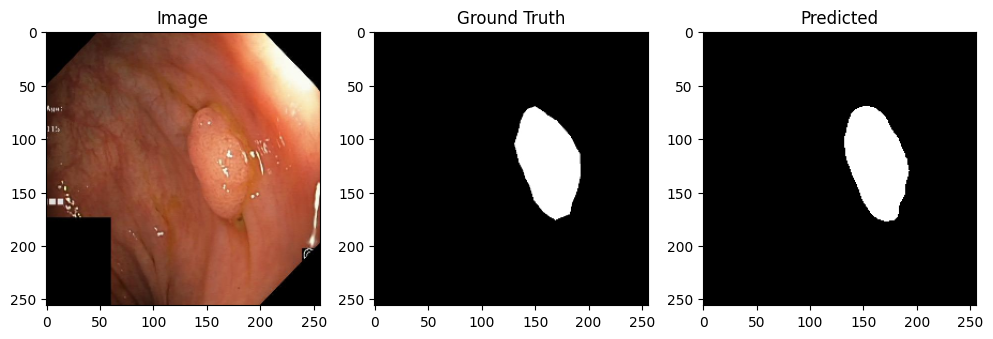

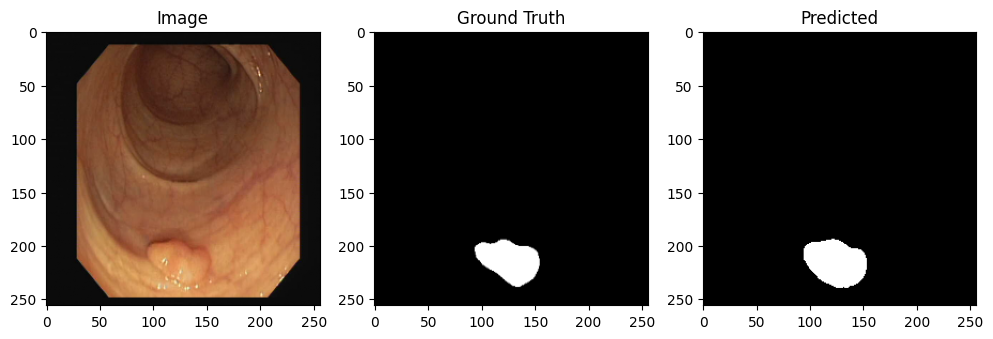

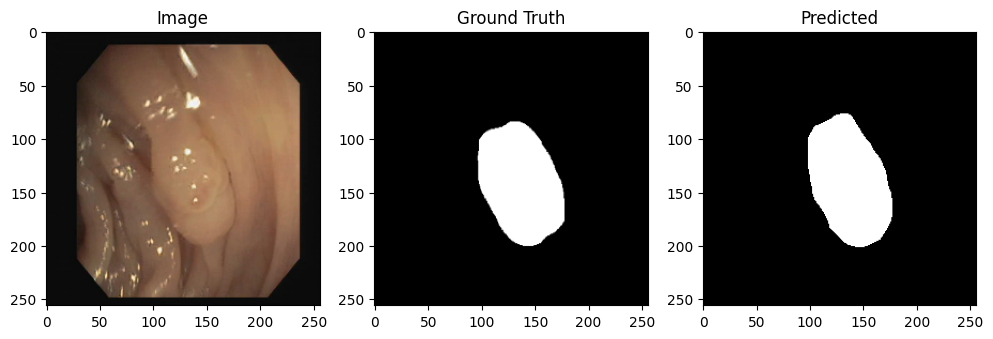

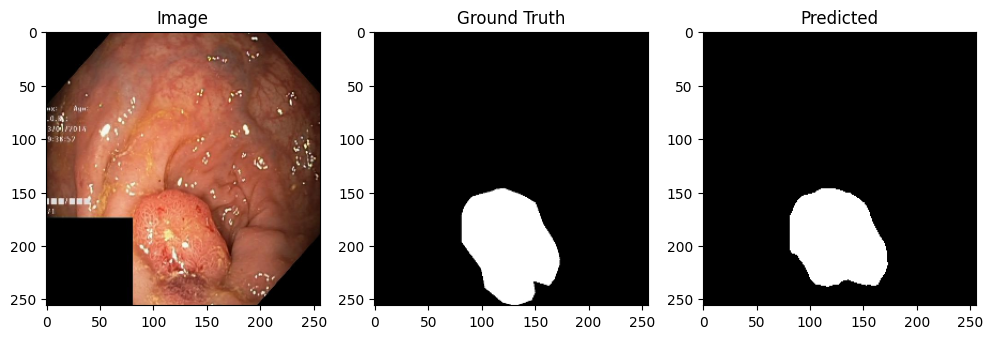

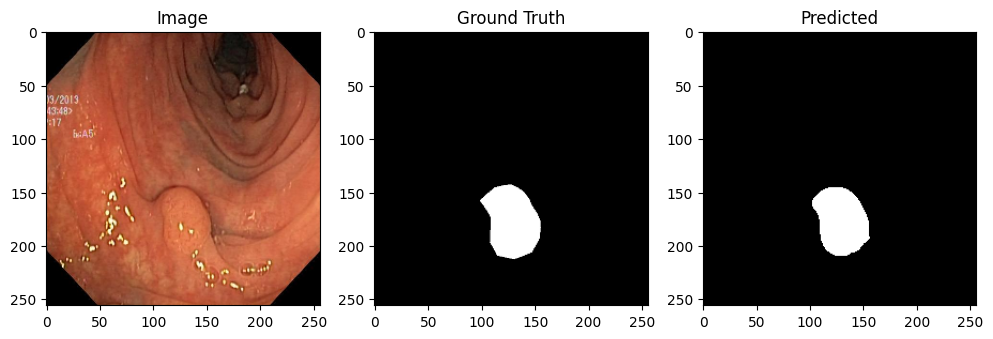

In [12]:
import matplotlib.pyplot as plt

first_10_images = test_images[:10]
first_10_true_labels = true_labels[:10]
first_10_predictions = binary_predictions[:10]

for i in range(10):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(first_10_images[i][...,::-1])
    plt.title('Image')
    
    plt.subplot(1, 3, 2)
    plt.imshow(first_10_true_labels[i], cmap='gray')
    plt.title('Ground Truth')

    plt.subplot(1, 3, 3)
    plt.imshow(first_10_predictions[i], cmap='gray')
    plt.title('Predicted')

    plt.show()

**The below code is for the testing of the UNet model with a CVC-300 polyp dataset**.

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def load_data2(path, split=0.1):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "masks/*")))

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    return (train_x, train_y)

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (256, 256))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x


path2 = "/kaggle/input/polyp-data/TestDataset/TestDataset/CVC-300"
(test_x_cvc_300, test_y_cvc_300) = load_data2(path2)

test_images_cvc_300 = [read_image(path2) for path2 in test_x_cvc_300]
test_images_cvc_300 = np.array(test_images_cvc_300)
prediction_test_cvc_300 = model.predict(test_images_cvc_300, batch_size=8)


true_labels_cvc_300 = [read_mask(path2) for path2 in test_y_cvc_300]
true_labels_cvc_300 = np.array(true_labels_cvc_300)

binary_predictions_cvc_300 = (prediction_test_cvc_300 > 0.5).astype(int)
y_test_bool_cvc_300 = (true_labels_cvc_300 > 0.5).astype(bool)
accuracy_test_cvc_300 = accuracy_score(np.ndarray.flatten(y_test_bool_cvc_300), np.ndarray.flatten(binary_predictions_cvc_300))
presision_score_test_cvc_300 = precision_score(np.ndarray.flatten(y_test_bool_cvc_300), np.ndarray.flatten(binary_predictions_cvc_300))
recall_score_test_cvc_300 = recall_score(np.ndarray.flatten(y_test_bool_cvc_300), np.ndarray.flatten(binary_predictions_cvc_300))


print(f'accuracy_cvc_300: {accuracy_test_cvc_300 * 100:.2f}%')
print(f'Precision_cvc_300:  {presision_score_test_cvc_300 * 100:.2f}%')
print(f'Recall_cvc_300 : {recall_score_test_cvc_300 * 100:.2f}%')

7/7 [==============================] - 7s 1s/step
accuracy_cvc_300: 97.60%
Precision_cvc_300:  59.22%
Recall_cvc_300 : 87.60%


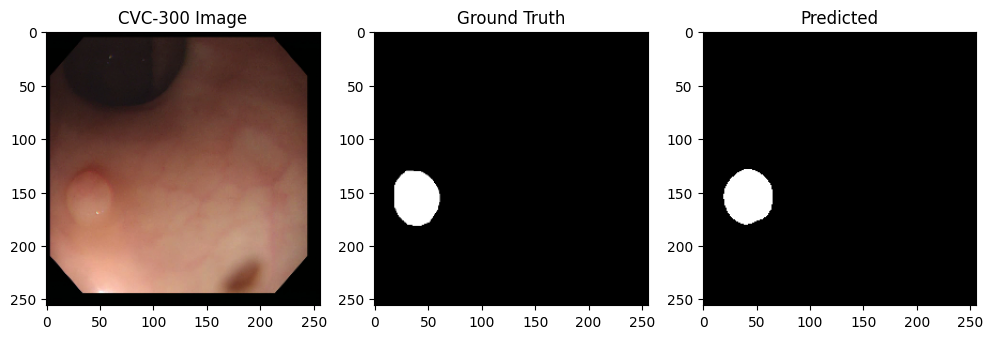

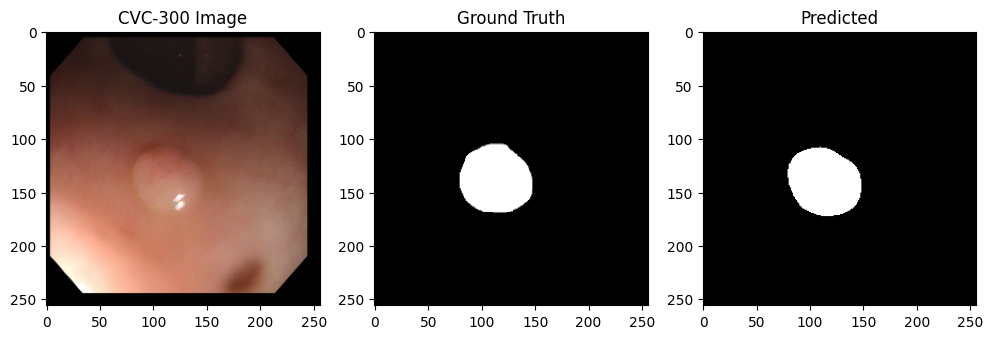

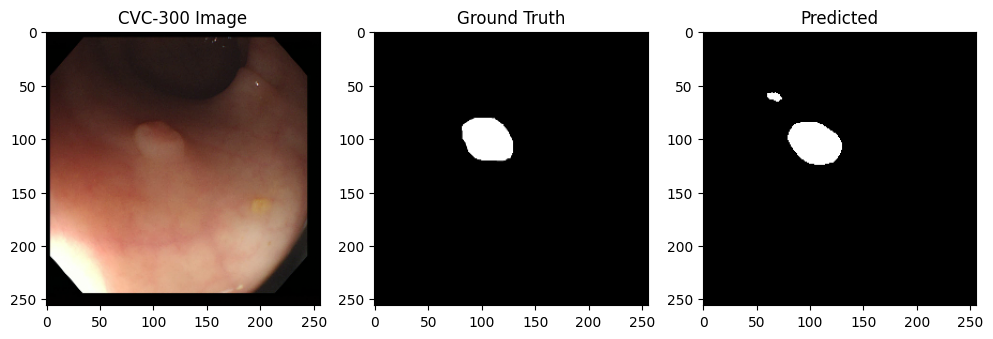

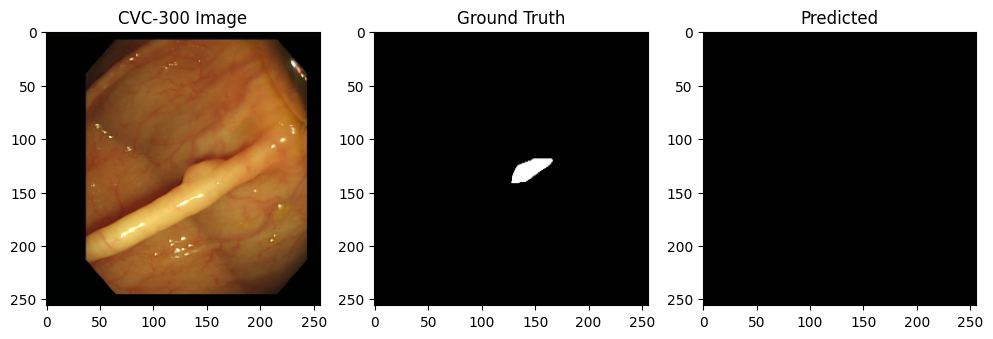

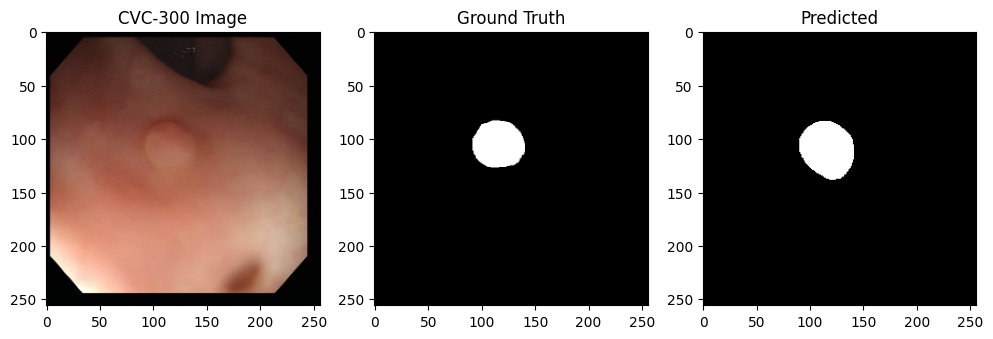

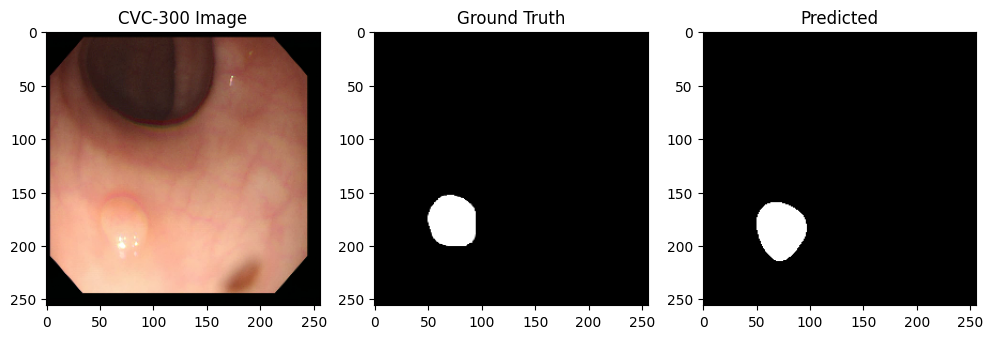

IndexError: index 6 is out of bounds for axis 0 with size 6

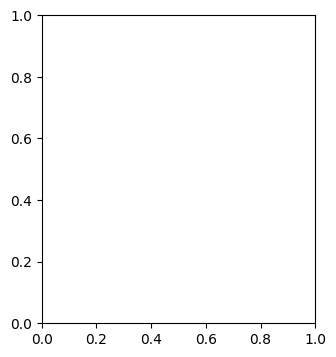

In [25]:
import matplotlib.pyplot as plt

first_6_images = test_images_cvc_300[:6]
first_6_true_labels = true_labels_cvc_300[:6]
first_6_predictions = binary_predictions_cvc_300[:6]

for i in range(10):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(first_6_images[i][...,::-1])
    plt.title('CVC-300 Image')
    
    plt.subplot(1, 3, 2)
    plt.imshow(first_6_true_labels[i], cmap='gray')
    plt.title('Ground Truth')

    plt.subplot(1, 3, 3)
    plt.imshow(first_6_predictions[i], cmap='gray')
    plt.title('Predicted')

    plt.show()

In [14]:
import tensorflow as tf
from tensorflow.keras.models import load_model
model_path = "/kaggle/input/polyp_unet_model/tensorflow1/default/1/model.h5"
with tf.keras.utils.custom_object_scope({'iou': iou, 's_measure': s_measure, 'mean_dice': s_measure, 'max_e_measure': max_e_measure, 'weighted_f_measure': weighted_f_measure}):
    loaded_model = load_model(model_path)

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def load_data3(path, split=0.1):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "masks/*")))

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    return (train_x, train_y)

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (256, 256))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x


path_CVC_ColonDB = "/kaggle/input/polyp-data/TestDataset/TestDataset/CVC-ColonDB"
(test_x_CVC_ColonDB, test_y_CVC_ColonDB) = load_data3(path_CVC_ColonDB)

test_images_CVC_ColonDB = [read_image(path_CVC_ColonDB) for path_CVC_ColonDB in test_x_CVC_ColonDB]
test_images_CVC_ColonDB = np.array(test_images_CVC_ColonDB)
prediction_test_CVC_ColonDB = loaded_model.predict(test_images_CVC_ColonDB, batch_size=8)


true_labels_CVC_ColonDB = [read_mask(path_CVC_ColonDB) for path_CVC_ColonDB in test_y_CVC_ColonDB]
true_labels_CVC_ColonDB= np.array(true_labels_CVC_ColonDB)

binary_predictions_CVC_ColonDB = (prediction_test_CVC_ColonDB > 0.5).astype(int)
y_test_bool_CVC_ColonDB = (true_labels_CVC_ColonDB > 0.5).astype(bool)
accuracy_test_CVC_ColonDB = accuracy_score(np.ndarray.flatten(y_test_bool_CVC_ColonDB), np.ndarray.flatten(binary_predictions_CVC_ColonDB))
presision_score_test_CVC_ColonDB = precision_score(np.ndarray.flatten(y_test_bool_CVC_ColonDB), np.ndarray.flatten(binary_predictions_CVC_ColonDB))
recall_score_test_CVC_ColonDB = recall_score(np.ndarray.flatten(y_test_bool_CVC_ColonDB), np.ndarray.flatten(binary_predictions_CVC_ColonDB))


print(f'accuracy_CVC_ColonDB: {accuracy_test_CVC_ColonDB * 100:.2f}%')
print(f'Precision_CVC_ColonDB:  {presision_score_test_CVC_ColonDB * 100:.2f}%')
print(f'Recall_CVC_ColonDB : {recall_score_test_CVC_ColonDB * 100:.2f}%')


43/43 [==============================] - 381s 9s/step
accuracy_CVC_ColonDB: 93.82%
Precision_CVC_ColonDB:  56.68%
Recall_CVC_ColonDB : 50.20%


In [22]:
dice_score_test_CVC_ColonDB = mean_dice(np.ndarray.flatten(y_test_bool_CVC_ColonDB), np.ndarray.flatten(binary_predictions_CVC_ColonDB))
iou_score_test_CVC_ColonDB = iou(np.ndarray.flatten(y_test_bool_CVC_ColonDB), np.ndarray.flatten(binary_predictions_CVC_ColonDB))
s_measure_score_test_CVC_ColonDB = s_measure(np.ndarray.flatten(y_test_bool_CVC_ColonDB), np.ndarray.flatten(binary_predictions_CVC_ColonDB))
# max_e_measure_score_test_CVC_ColonDB = max_e_measure(np.ndarray.flatten(y_test_bool_CVC_ColonDB), np.ndarray.flatten(binary_predictions_CVC_ColonDB))
weighted_f_measure_score_test_CVC_ColonDB = weighted_f_measure(np.ndarray.flatten(y_test_bool_CVC_ColonDB), np.ndarray.flatten(binary_predictions_CVC_ColonDB))

print(f'Mean_Dice_CVC_ColonDB: {dice_score_test_CVC_ColonDB * 100:.2f}%')
print(f'IOU_CVC_ColonDB: {iou_score_test_CVC_ColonDB * 100:.2f}%')
print(f'S_measure_CVC_ColonDB: {s_measure_score_test_CVC_ColonDB * 100:.2f}%')
# print(f'Max_E_measure_CVC_ColonDB: {max_e_measure_score_test_CVC_ColonDB * 100:.2f}%')
print(f'Weighted_F_measure_CVC_ColonDB: {weighted_f_measure_score_test_CVC_ColonDB * 100:.2f}%')

Mean_Dice_CVC_ColonDB: 53.25%
IOU_CVC_ColonDB: 36.28%
S_measure_CVC_ColonDB: 67.74%
Weighted_F_measure_CVC_ColonDB: 53.25%


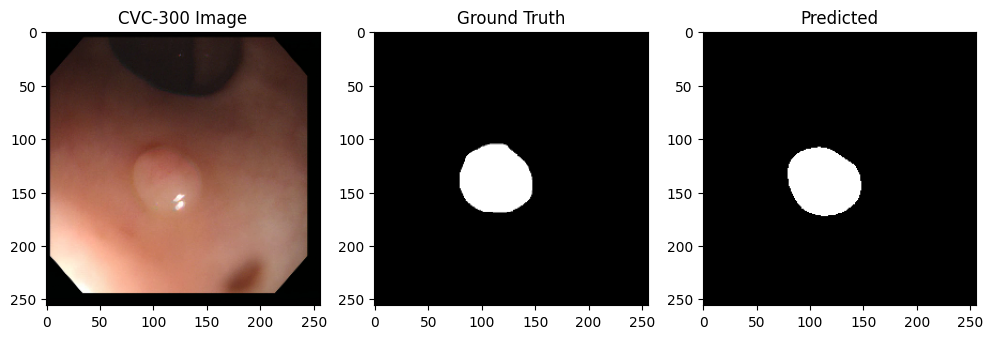

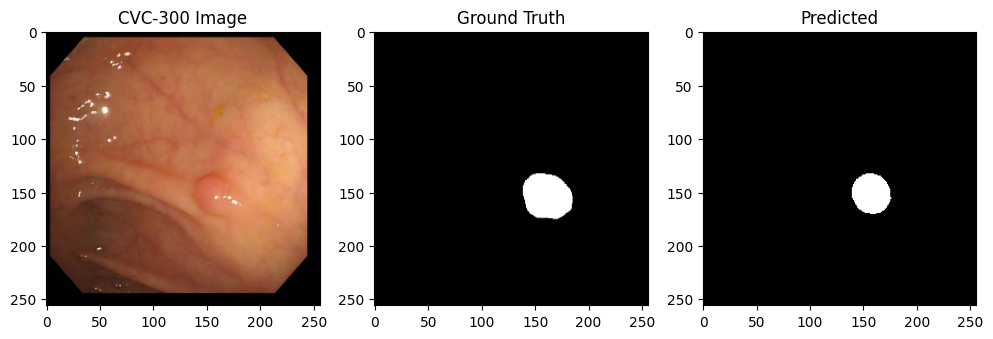

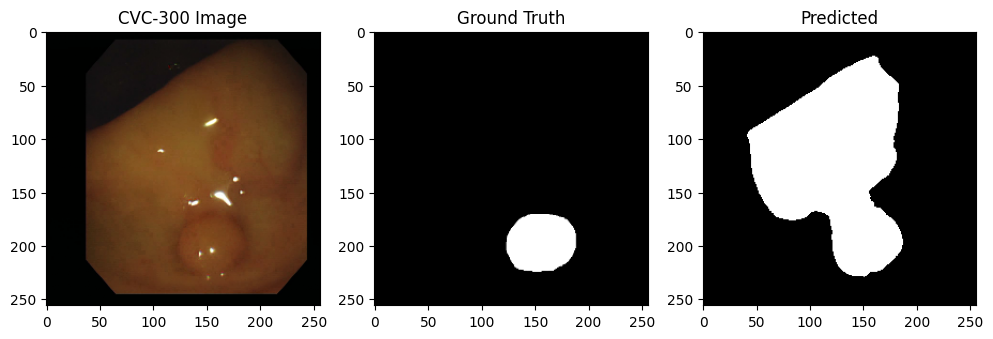

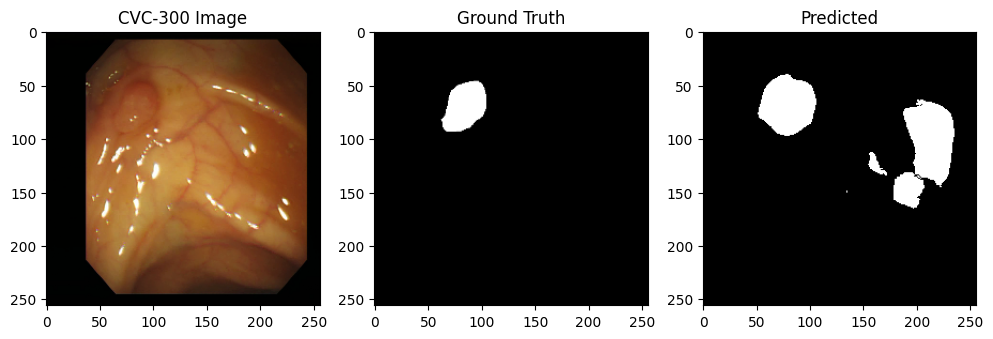

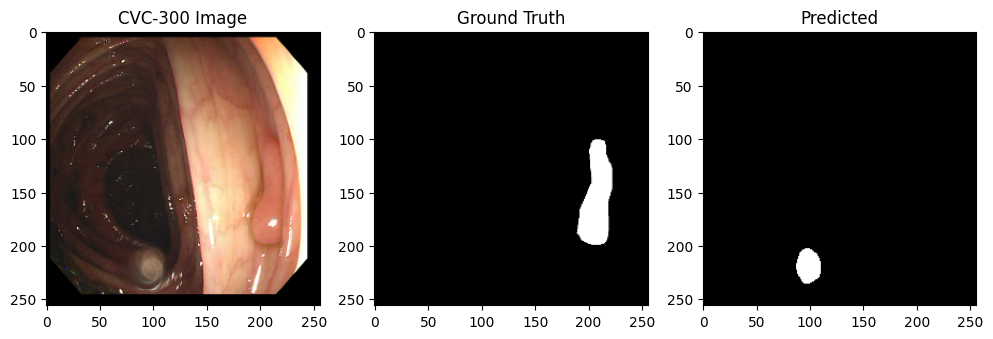

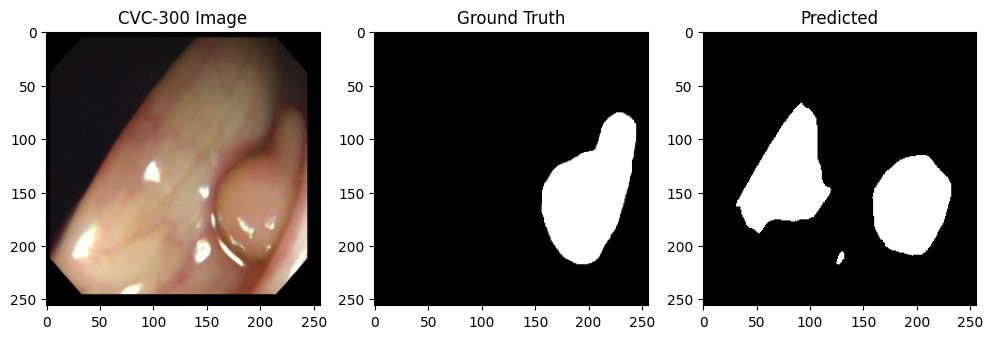

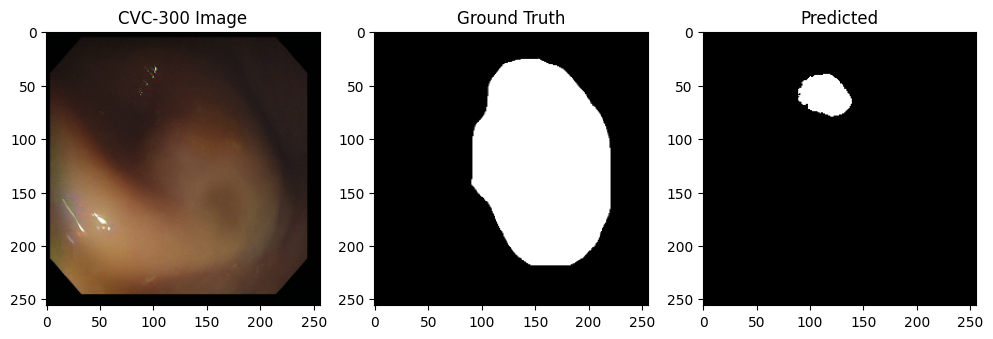

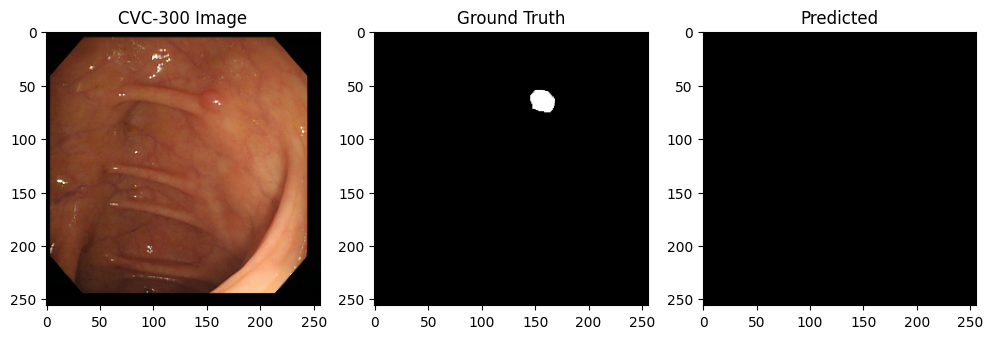

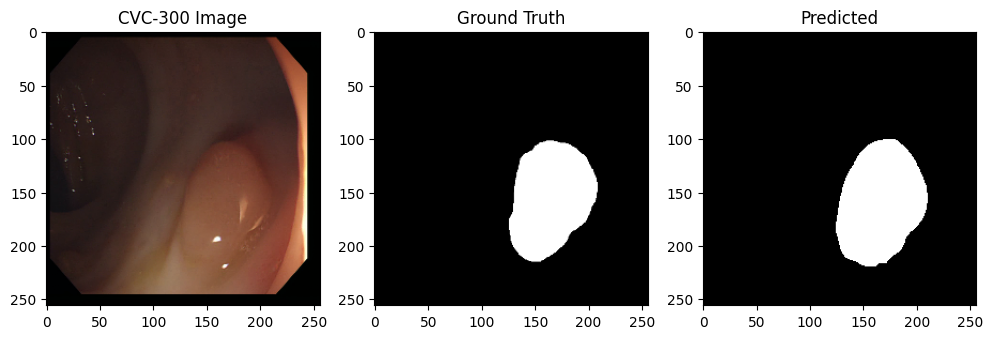

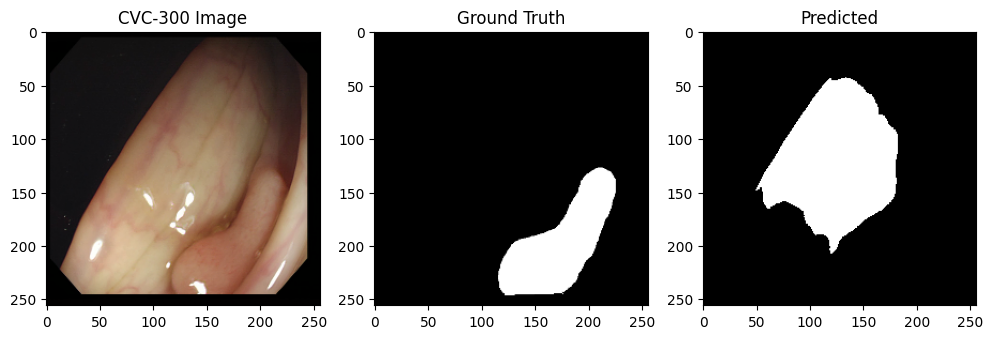

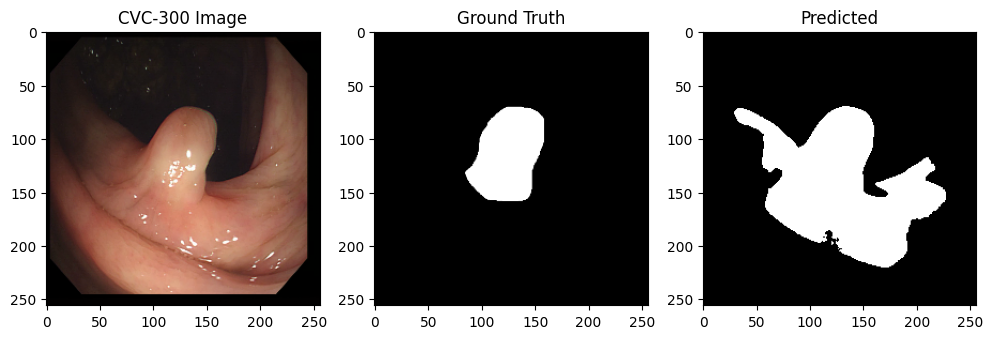

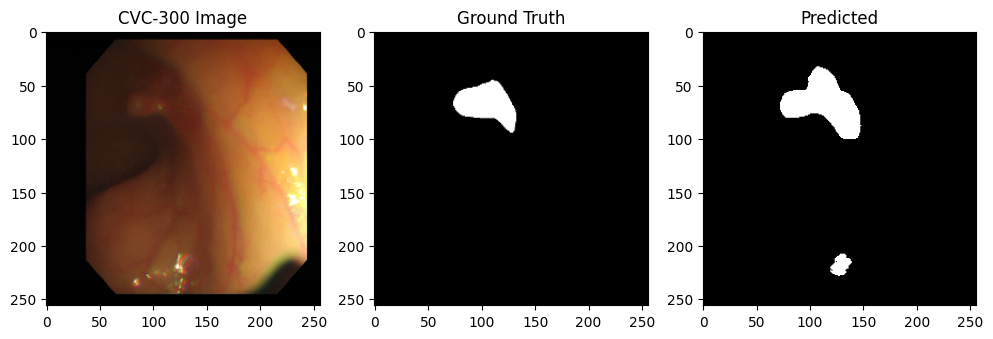

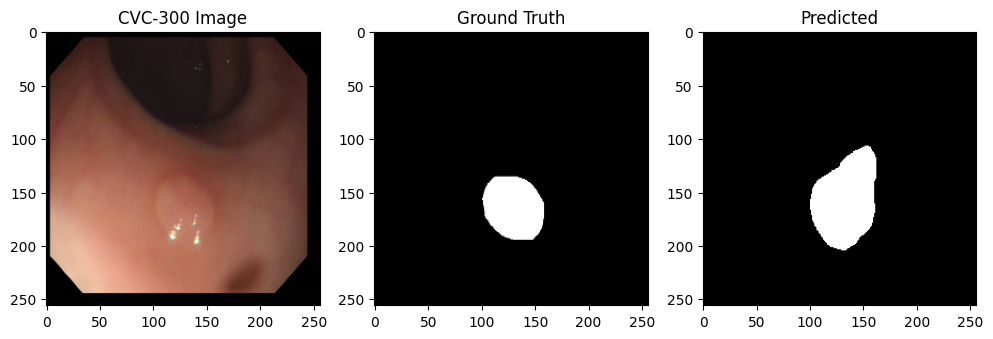

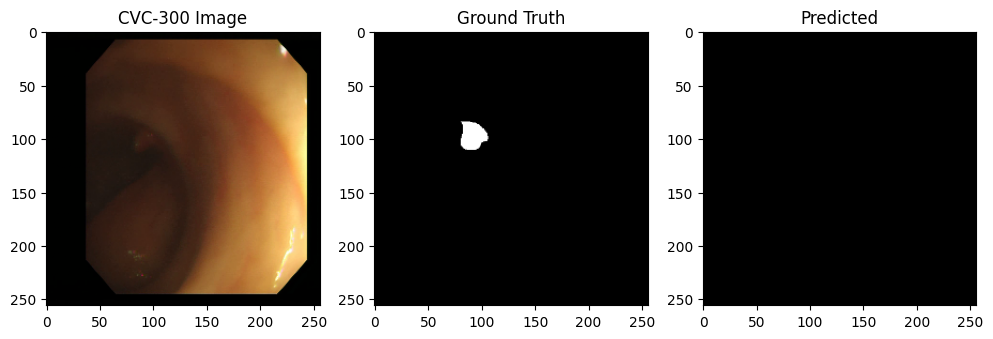

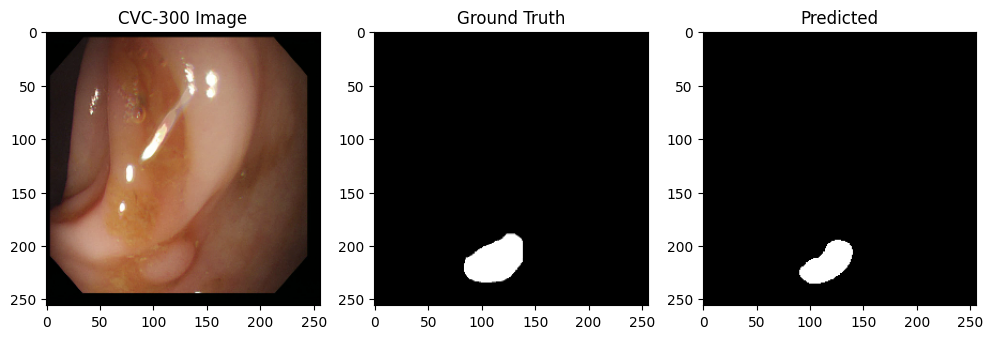

In [23]:
import matplotlib.pyplot as plt

first_15_images = test_images_CVC_ColonDB[:15]
first_15_true_labels = true_labels_CVC_ColonDB[:15]
first_15_predictions = binary_predictions_CVC_ColonDB[:15]

for i in range(15):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(first_15_images[i][...,::-1])
    plt.title('CVC-300 Image')
    
    plt.subplot(1, 3, 2)
    plt.imshow(first_15_true_labels[i], cmap='gray')
    plt.title('Ground Truth')

    plt.subplot(1, 3, 3)
    plt.imshow(first_15_predictions[i], cmap='gray')
    plt.title('Predicted')

    plt.show()